[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[[1000 1019]
 [ 945 1036]]
              precision    recall  f1-score   support

         0.0       0.51      0.50      0.50      2019
         1.0       0.50      0.52      0.51      1981

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000

0.509
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  29.7s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  16.2s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  18.0s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time=  22.6s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time=  26.7s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time=  26.7s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=400; total time=  31.4s
[CV] END ..l

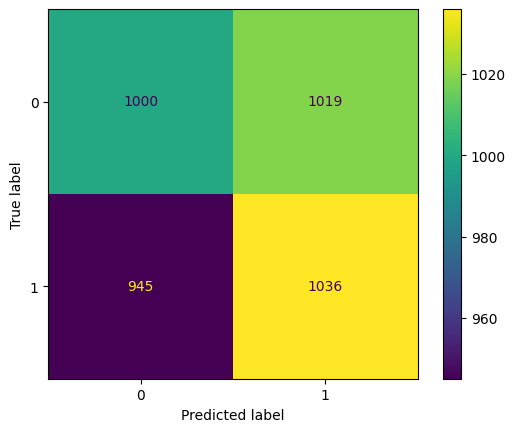

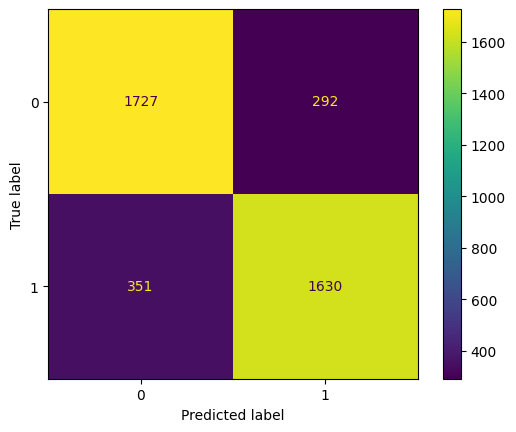

In [7]:
# Install necessary libraries
!pip install xgboost datasets scikit-learn nltk

# Import libraries
import pandas as pd
import re
from datasets import load_dataset
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from scipy.sparse import hstack
import xgboost as xgb
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt

# Download NLTK stopwords
nltk.download('stopwords')

# Load Amazon Reviews Dataset
ds = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
df = ds["full"].to_pandas()

# Simplify ratings: 1-3 stars as 0 (negative), 4-5 stars as 1 (positive)
df["rating"] = df["rating"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})

# Balance the dataset by sampling
df = df.groupby("rating").sample(n=10000, random_state=42)

# Preprocessing: Remove special characters and lowercase
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Remove multiple spaces
    text = text.lower()  # Convert to lowercase
    return text

df["text"] = df["text"].apply(preprocess_text)

# Add auxiliary features
df["text_length"] = df["text"].apply(len)
df["word_count"] = df["text"].apply(lambda x: len(x.split()))
df["avg_word_length"] = df["text_length"] / (df["word_count"] + 1)

# Reset indices to ensure alignment across datasets
df.reset_index(drop=True, inplace=True)

# Split into features and labels
features = df["text"]
labels = df["rating"]
aux_features = df[["text_length", "word_count", "avg_word_length"]]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Baseline
text_classifier = DummyClassifier(strategy="uniform")
text_classifier.fit(X_train, y_train.values.ravel())

# Baseline Model Accuracy
predictions = text_classifier.predict(X_test)

base_CM = confusion_matrix(y_test, predictions)
print(base_CM)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

ConfusionMatrixDisplay(confusion_matrix=base_CM).plot()


# Align auxiliary features with the train-test split
aux_train, aux_test = aux_features.iloc[X_train.index], aux_features.iloc[X_test.index]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.9, stop_words=stopwords.words("english"))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Combine TF-IDF and auxiliary features
X_train_combined = hstack([X_train_tfidf, aux_train])
X_test_combined = hstack([X_test_tfidf, aux_test])

# Train XGBoost Classifier with GridSearchCV
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.2],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    verbose=2
)

# Train the model with grid search
grid_search.fit(X_train_combined, y_train)

# Use the best model
best_xgb_model = grid_search.best_estimator_

# Predict on test data
predictions = best_xgb_model.predict(X_test_combined)

# Evaluate the model
CM = confusion_matrix(y_test, predictions)
print(CM)
print(classification_report(y_test, predictions))
print(f"Accuracy: {accuracy_score(y_test, predictions)}")

ConfusionMatrixDisplay(confusion_matrix=CM).plot()
plt.show()